# Problemas de Advección

## Esquemas numéricos para PDEs hiperbólicas

## Luz roja!

Exploremos el comportamiento de diferentes esquemas numericos para una onda de choque en movimiento. En el contexto del modelo de trafico vehicular tratado en el cuaderno previo, imagine una autopista *altamente congestionada* y un semaforo ubicado en $x=4$. Los autos se acumulan rapidamente en el frente, donde tenemos la densidad maxima permitida de autos entre $x=3$ y $x=4$, y hay un trafico entrante equivalente al 50% de la maxima densidad permitida $(\rho=0.5\rho_{\rm max})$. 

Matematicamente, esto es:

$$
\begin{equation}
\rho(x,0) = \left\{
\begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}
$$

Veamos entonces como luce la condicion inicial.

In [12]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [13]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [14]:
def rho_red_light(x, rho_max):
    """
    Computes the "red light" initial condition with shock.
    
    Parameters
    ----------
    x : numpy.ndaray
        Locations on the road as a 1D array of floats.
    rho_max : float
        The maximum traffic density allowed.
    
    Returns
    -------
    rho : numpy.ndarray
        The initial car density along the road
        as a 1D array of floats.
    """
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho

In [15]:
# Set parameters.
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 40  # number of time steps to compute
rho_max = 10.0  # maximum traffic density allowed
u_max = 1.0  # maximum speed traffic

# Get the road locations.
x = numpy.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_red_light(x, rho_max)

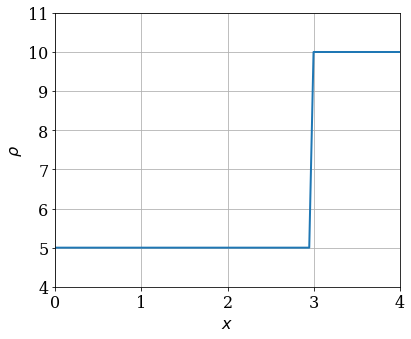

In [39]:
# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 5.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

La cuestion a responder seria: **De que forma los autos se acumulan en la luz roja del semaforo?** 

Procuraremos resolver este problema empleando diferentes esquemas numericos, para evaluar su desempeño. Estos esquemas son:

   * Lax-Friedrichs
   * Lax-Wendroff
   * MacCormack

Con respecto a la ecuacion a resolver, notamos que la velocidad de onda $u_{\rm wave}$ es $-1$ para $\rho = \rho_{\rm max}$ y por otra parte se verifica $\rho \geq \rho_{\rm max}/2$, haciendo negativas todas las velocidades de onda. Deberiamos ver una solucion que se mueve hacia la izquierda, conservando la geometria de la onda de choque.

![squarewave](./figuras/squarewave.png)

En primer lugar, definamos algunas funciones utiles.

In [40]:
def flux(rho, u_max, rho_max):
    """
    Computes the traffic flux F = V * rho.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    rho_max : float
        Maximum car density allowed on the road.
    
    Returns
    -------
    F : numpy.ndarray
        The traffic flux along the road as a 1D array of floats.
    """
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

Generemos la funcion para actualizar la figura Matplotlib durante la animacion.

In [41]:
from matplotlib import animation
from IPython.display import HTML

In [42]:
def update_plot(n, rho_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

## Esquema de Lax-Friedrichs 

Recordemos la ley de conservacion para el trafico vehicular, resultando en la siguiente ecuacion para la densidad de trafico:

$$
\begin{equation}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0
\end{equation}
$$

$F$ es el *flujo de trafico*, el cual se encuentra dado en el modelo lineal por la siguiente expresion: 

$$
\begin{equation}
F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}
$$

En la variable tiempo, la eleccion natural para la discretizacion es una formula de diferencias *hacia adelante*:

$$
\begin{equation}
\frac{\partial \rho}{\partial t}\approx \frac{1}{\Delta t}( \rho_i^{n+1}-\rho_i^n )
\end{equation}
$$

En un problema de adveccion, el empleo de una discretizacion de primer orden en espacio conduce a una excesiva difusion numerica, tal como es posible observar en el [Cuaderno 1 del Modulo 2](../modulo2/02_01_Conveccion1D.ipynb). La aproximacion mas simple la cual nos permite obtener una precision de segundo orden en espacio consiste en un esquema en diferencias centrado:

$$
\begin{equation}
\frac{\partial F}{\partial x} \approx \frac{1}{2\Delta x}( F_{i+1}-F_{i-1})
\end{equation}
$$

Sin embargo, la combinacion de ambos esquemas de discretizacion en tiempo y espacio para la ecuacion de adveccion presenta resultados catastroficos! El esquema *forward-time / central-space* (FTCS) es **inestable**.

El esquema de Lax-Friedrichs ha sido propuesto por Lax (1954) como un astuto artilugio para estabilizar el esquema FTCS. Su idea fue reemplazar el valor de la solucion en $\rho^n_i$ por el promedio de los valores en los puntos de grilla vecinos. Si efectuamos tal reemplazo, conseguimos la siguiente ecuacion discretizada: 

$$
\begin{equation}
\frac{\rho_i^{n+1}-\frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1})}{\Delta t} = -\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x}
\end{equation}
$$

Notamos que la formula en diferencias **no** usa mas el valor en $\rho^n_i$ a fin de obtener $\rho^{n+1}_i$. El *stencil* del esquema de Lax-Friedrichs es ligeramente diferente del *stencil* asociado al esquema FTCS.

![Stencil of the forward-time central scheme](./figuras/FD-stencil_FTCS.png)
#### Stencil del esquema FTCS.

![Stencil of the Lax-Friedrichs scheme](./figuras/FD-stencil_LF.png)
#### Stencil del esquema de Lax-Friedrichs.

Esta discretizacion numerica es **estable**. Desafortunadamente, el reemplazo de $\rho^n_i$ por el promedio de sus vecinos introduce un error de primer orden.

A fin de implementar el esquema en el codigo, aislamos el valor en el proximo paso de tiempo, $\rho^{n+1}_i$:

$$
\begin{equation}
\rho_i^{n+1} = \frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1}) - \frac{\Delta t}{2 \Delta x}(F^n_{i+1}-F^n_{i-1})
\end{equation}
$$

La funcion siguiente implementa Lax-Friedrichs para nuestro modelo de trafico.

Para generar la animacion, almacenaremos el resultado de cada paso de tiempo en la variable `rho`, un vector 2D. El vector resultante `rho_n` tendra `nt` filas y `nx` columnas.

In [43]:
def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using Lax-Friedrichs scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time using Lax-Friedrichs scheme.
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

### Lax-Friedrichs con $\frac{\Delta t}{\Delta x}=1$

En primer lugar, probemos con CFL=1

In [44]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [46]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_jshtml())

##### Think

<div class="alert alert-block alert-info">
    
<li>What do you see in the animation above? How does the numerical solution compare with the exact solution (a left-traveling shock wave)?</li> 
<li>What types of errors do you think we see?</li> 
<li>What do you think of the Lax-Friedrichs scheme, so far?</li>
    
</div>   

### Lax-Friedrichs con $\frac{\Delta t}{\Delta x} = 0.5$

Mejorara la solucion si empleamos un paso de tiempo mas pequeño? Verifiquemos!

In [47]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [48]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_jshtml())

##### Dig deeper

<div class="alert alert-block alert-success">
Notice the strange "staircase" behavior on the leading edge of the wave?  You may be interested to learn more about this: a feature typical of what is sometimes called "odd-even decoupling." Last year we published a collection of lessons in Computational Fluid Dynamics, called <b>CFD Python</b>, where we discuss
<a href="https://nbviewer.jupyter.org/github/barbagroup/CFDPython/blob/14b56718ac1508671de66bab3fe432e93cb59fcb/lessons/19_Odd_Even_Decoupling.ipynb">odd-even decoupling</a>. 

How does this solution compare with the previous one, where the Courant number was $\frac{\Delta t}{\Delta x}=1$?
</div>    

## Esquema de Lax-Wendroff

El metodo de Lax-Friedrichs emplea un truco para estabilizar el esquema centrado para la adveccion, pero al hacerlo pierde un orden de precision. Los metodos de primer orden **NO** son suficientemente buenos para tratar problemas de adveccion, especialmente cuando se dispone de gradientes abruptos (choques).

El metodo de Lax-Wendroff (1960) fue el *primer* esquema en alcanzar una precision de segundo orden en tiempo y espacio. Para desarrollar este esquema, comencemos con la expansion en serie de Taylor (en la variable tiempo) alrededor de $\rho^{n+1}$:

$$
\begin{equation}
\rho^{n+1} = \rho^n + \frac{\partial\rho^n}{\partial t} \Delta t + \frac{(\Delta t)^2}{2}\frac{\partial^2\rho^n}{\partial t^2} + \ldots
\end{equation}
$$

Para la ley de conservacion con $F=F(\rho)$, y empleando la regla de la cadena, podemos escribir:

$$
\begin{equation}
\frac{\partial \rho}{\partial t} = -\frac{\partial F}{\partial x} = -\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = -J \frac{\partial \rho}{\partial x}
\end{equation}
$$

donde 

$$
\begin{equation}
J = \frac{\partial F}{\partial \rho} = u _{\rm max} \left(1-2\frac{\rho}{\rho_{\rm max}} \right)
\end{equation}
$$

es el *Jacobiano* asociado al modelo de trafico. A continuacion, usamos un truco:

$$
\begin{equation}
\frac{\partial F}{\partial t} = \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial t} = J \frac{\partial \rho}{\partial t} = -J \frac{\partial F}{\partial x}
\end{equation}
$$

En el paso anterior, hemos empleado la ecuacion diferencial del modelo de trafico para reemplazar la derivada temporal por una derivada espacial. Esta equivalencia implica que:

$$
\begin{equation}
\frac{\partial^2\rho}{\partial t^2} = \frac{\partial}{\partial x} \left( J \frac{\partial F}{\partial x} \right)
\end{equation}
$$

Reemplazando en la expansion de Taylor:

$$
\begin{equation}
\rho^{n+1} = \rho^n - \frac{\partial F^n}{\partial x} \Delta t + \frac{(\Delta t)^2}{2} \frac{\partial}{\partial x} \left(J\frac{\partial F^n}{\partial x} \right)+ \ldots
\end{equation}
$$

Reorganizando y discretizando las derivadas espaciales por medio de diferencias centradas obtenemos la siguiente ecuacion discreta:

$$
\begin{equation}
\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} = -\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x} + \frac{\Delta t}{2} \left(\frac{(J \frac{\partial F}{\partial x})^n_{i+\frac{1}{2}}-(J \frac{\partial F}{\partial x})^n_{i-\frac{1}{2}}}{\Delta x}\right)
\end{equation}
$$

Ahora, aproximamos el termino entre parentesis como sigue:

\begin{equation} \frac{J^n_{i+\frac{1}{2}}\left(\frac{F^n_{i+1}-F^n_{i}}{\Delta x}\right)-J^n_{i-\frac{1}{2}}\left(\frac{F^n_i-F^n_{i-1}}{\Delta x}\right)}{\Delta x}\end{equation}

Entonces, evaluamos el Jacobiano en los puntos intermedios empleando promedios de los puntos a cada lado:

\begin{equation}\frac{\frac{1}{2 \Delta x}(J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-\frac{1}{2 \Delta x}(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})}{\Delta x}.\end{equation}

Nuestra ecuacion se escribe:

\begin{align}
&\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} =  
-\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x} + \cdots \\ \nonumber 
&+ \frac{\Delta t}{4 \Delta x^2} \left( (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right)
\end{align}

Resolviendo para $\rho_i^{n+1}$:

\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

con

\begin{equation}J^n_i = \frac{\partial F}{\partial \rho} = u_{\rm max} \left(1-2\frac{\rho^n_i}{\rho_{\rm max}} \right).\end{equation}

In [49]:
def jacobian(rho, u_max, rho_max):
    """
    Computes the Jacobian for our traffic model.
    
    Parameters
    ----------
    rho : numpy.ndarray
       Traffic density along the road as a 1D array of floats.
    u_max : float
        Maximum speed allowed on the road.
    rho_max : float
        Maximum car density allowed on the road.
    
    Returns
    -------
    J : numpy.ndarray
        The Jacobian as a 1D array of floats.
    """
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

In [50]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using Lax-Wendroff scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the
        flux and Jacobien functions.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Compute the Jacobian.
        J = jacobian(rho, *args)
        # Advance in time using Lax-Wendroff scheme.
        rho[1:-1] = (rho[1:-1] -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                     dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) -
                      (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

Ahora que hemos definido una funcion para el esquema de Lax-Wendroff, seguiremos el procedimiento habitual para animar y visualizar nuestros resultados.  

### Lax-Wendroff con $\frac{\Delta t}{\Delta x}=1$

In [53]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [54]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_jshtml())

<div class="alert alert-block alert-danger">
Interesting! The Lax-Wendroff method captures the sharpness of the shock much better than the Lax-Friedrichs scheme, but there is a new problem: a strange wiggle appears right at the tail of the shock. This is typical of many second-order methods: they introduce <b>numerical oscillations</b> where the solution is not smooth. Bummer.
</div>

### Lax-Wendroff con $\frac{\Delta t}{\Delta x} =0.5$

De que manera se modifican las oscilaciones presentes en el frente de onda al cambiar la condicion CFL? Podriamos imaginar que la solucion mejora si hacemos el paso de tiempo mas pequeño ... veamos!

In [55]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [56]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_jshtml())

<div class="alert alert-block alert-danger">
Eek! The numerical oscillations got worse. Double bummer!

Why do we observe oscillations with second-order methods? This is a question of fundamental importance!
</div>    

## Esquema de MacCormack

Las oscilaciones numericas observadas con el metodo de Lax-Wendroff en el modelo de trafico pueden llegar a ser severas en algunos problemas. Pero en realidad la principal desventaja del metodo de Lax-Wendroff consiste en tener que calcular el Jacobiano en cada paso de tiempo. Con ecuaciones mas complicadas, este calculo conlleva un alto costo computacional.  

El esquema de MacCormack es un metodo de dos pasos, en el cual el primer paso es llamado *predictor* y el segundo paso es llamado *corrector*. El mismo alcanza una precision de segundo orden tanto en tiempo como en espacio. Una version del mismo se escribe:  

$$
\begin{equation}
\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i}) \ \ \ \ \ \ \text{(predictor)}
\end{equation}
$$

$$
\begin{equation}
\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1})) \ \ \ \ \ \ \text{(corrector)}
\end{equation}
$$

Si observamos con detalle, el primer paso tiene la apariencia de un esquema *forward-time/forward-space*, mientras que el segundo paso aparenta ser un esquema *forward-time/backward-space*, promediado con el primer resultado. La ventaja de esta caracteristica reside en la posibilidad de tratar problemas con ondas que viajen en ambas direcciones (izquierda y derecha), y el esquema de MacCormack devolvera un metodo estable (sujeto a la condicion CFL). Probemoslo!

In [57]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    """
    Computes the traffic density on the road 
    at a certain time given the initial traffic density.
    Integration using MacCormack scheme.
    
    Parameters
    ----------
    rho0 : numpy.ndarray
        The initial traffic density along the road
        as a 1D array of floats.
    nt : integer
        The number of time steps to compute.
    dt : float
        The time-step size to integrate.
    dx : float
        The distance between two consecutive locations.
    bc_values : 2-tuple of floats
        The value of the density at the first and last locations.
    args : list or tuple
        Positional arguments to be passed to the flux function.
    
    Returns
    -------
    rho_hist : list of numpy.ndarray objects
        The history of the car density along the road.
    """
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Predictor step of the MacCormack scheme.
        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))
        # Compute the flux.
        F = flux(rho_star, *args)
        # Corrector step of the MacCormack scheme.
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

### MacCormack con $\frac{\Delta t}{\Delta x} = 1$

In [58]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [59]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_jshtml())

### MacCormack con $\frac{\Delta t}{\Delta x}= 0.5$

Una vez mas, nos preguntamos: de que forma el numero CFL afecta el error? Cual da mejores resultados? Veamos.

In [60]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [61]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
# Display the video.
HTML(anim.to_jshtml())

##### Dig Deeper

<div class="alert alert-block alert-success">
You can also obtain a MacCormack scheme by reversing the predictor and corrector steps. For shocks, the best resolution will occur when the difference in the predictor step is in the direction of propagation. Try it out! Was our choice here the ideal one? In which case is the shock better resolved?
</div>

##### Challenge task

<div class="alert alert-block alert-info">
In the <i>red light</i> problem, $\rho \geq \rho_{\rm max}/2$, making the wave speed negative at all points. You might be wondering why we introduced these new methods; couldn't we have just used a forward-time/forward-space scheme? But, what if $\rho_{\rm in} < \rho_{\rm max}/2$? Now, a whole region has negative wave speeds and forward-time/backward-space is unstable. 
<li>How do Lax-Friedrichs, Lax-Wendroff and MacCormack behave in this case? Try it out!</li>
<li>As you decrease $\rho_{\rm in}$, what happens to the velocity of the shock? Why do you think that happens?</li>
</div> 

## Referencias

* Peter D. Lax (1954), "Weak solutions of nonlinear hyperbolic equations and their numerical computation," _Commun. Pure and Appl. Math._, Vol. 7, pp. 159–193.

* Peter D. Lax and Burton Wendroff (1960), "Systems of conservation laws,"  _Commun. Pure and Appl. Math._, Vol. 13, pp. 217–237.

* R. W. MacCormack (1969), "The effect of viscosity in hypervelocity impact cratering," AIAA paper 69-354. Reprinted on _Journal of Spacecraft and Rockets_, Vol. 40, pp. 757–763 (2003). Also on _Frontiers of Computational Fluid Dynamics_, edited by D. A. Caughey, M. M. Hafez (2002), chapter 2: [read on Google Books](http://books.google.com/books?id=QBsnMOz_8qcC&lpg=PA27&ots=uqCeuH1U6S&lr&pg=PA27#v=onepage&q&f=false).

* R. W. MacCormack (1971), "Numerical solution of the interaction of a shock wave with a laminar boundary layer," _Proceedings of the 2nd Int. Conf. on Numerical Methods in Fluid Dynamics_, Lecture Notes in Physics, Vol. 8, Springer, Berlin, pp. 151–163. 

---

###### The cell below loads the style of the notebook.

In [63]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())